### Index

- [Problem Statement](#Problem-Statement)
- [Importing Libraries and Macros](#Importing-Libraries)
- [Exploratory Data Analysis and Preprocessing](#Exploratory-Data-Analysis-and-Preprocessing)
- [Feature Extraction from text data](#Feature-Extraction-from-text-data)
- [Building the Model](#Building-the-Model)

<a id='Problem Statement'></a>

### Problem Statement (Data can be found in Kaggle)

Given details about a product like product category name, brand name, and item condition, Can you build an algorithm that automatically suggests the right product prices? Quite challenging, right?
But if solved rightly, it can eliminate human interference in giving price suggestions of a product and speed up efficiency of the shopping app. That’s when Machine Learning comes to play.\
For a given item, we need to suggest the price of that item given its different features like category, name, brand name, item description etc. 
The given problem is a Regression problem as it will return the price of an item which is a real-valued value.


 - train_id or test_id - the id of the listing
 - name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. 20) to avoid leakage. These removed prices are represented as [rm].
 - item_condition_id - the condition of the items provided by the seller
 - category_name - category of the listing
 - brand_name
 - **price** - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
 - shipping - 1 if shipping fee is paid by seller and 0 by buyer
 - item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. 20) to avoid leakage. These removed prices are represented as [rm]
 
 


<a id='Importing Libraries'></a>

### Importing Libraries

In [4]:
%store -r __importRegression
%store -r __importNLP

In [147]:
# Macros with all the libabries to be imported

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")

from scipy.sparse import hstack
from scipy.sparse import csr_matrix


In [7]:
__importRegression

In [142]:
__importNLP

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

In [98]:
train = pd.read_csv("train.tsv",  sep='\t')
test = pd.read_csv("test.tsv",  sep='\t')

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [99]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


<a id='Exploratory Data Analysis and Preprocessing'></a>

### Exploratory Data Analysis and Preprocessing

#### Step-1 (Filling Null Values)

In [100]:
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [101]:
def fill_null_values(df):
    df.category_name.fillna("Category_not_Given",inplace=True)
    df.brand_name.fillna("brand_not_Given",inplace=True)
    
    df.item_description.fillna("No description yet",inplace=True)
    #Already there is "no description yet" in some rows, thats why I am filling the same in Null also
    
    return df

In [102]:
fill_null_values(train).isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
dtype: bool

In [103]:
fill_null_values(test).isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name        False
brand_name           False
shipping             False
item_description     False
dtype: bool

In [104]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


#### Step-2 (Splitting Categories)

In [105]:
def cat_split(row):
    try:
        text = row
        text1, text2, text3 = text.split('/')
        return text1, text2, text3
    except:
        return ("Label not given", "Label not given", "Label not given")

In [106]:
def creating_col_category(df):
    
    df['general_cat'], df['subcat_1'], df['subcat_2'] = \
    zip(*df['category_name'].apply(lambda x: cat_split(x)))
    
    return df

In [107]:
#what Does zip(*) do?

list(zip(*train.head()['category_name'].apply(lambda x: cat_split(x))))

[('Men', 'Electronics', 'Women', 'Home', 'Women'),
 ('Tops', 'Computers & Tablets', 'Tops & Blouses', 'Home Décor', 'Jewelry'),
 ('T-shirts',
  'Components & Parts',
  'Blouse',
  'Home Décor Accents',
  'Necklaces')]

In [108]:
creating_col_category(test)
creating_col_category(train).head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,brand_not_Given,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,brand_not_Given,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,brand_not_Given,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [109]:
for col in ["general_cat","subcat_1","subcat_2","brand_name"]:
    print ("No of Unique items in " , col ," is " ,train[col].nunique())

No of Unique items in  general_cat  is  11
No of Unique items in  subcat_1  is  114
No of Unique items in  subcat_2  is  865
No of Unique items in  brand_name  is  4810


In [112]:
print(train.shape)
print(test.shape)

(1482535, 11)
(693359, 10)


#### Step-3 (Analyzing Price Distribution)

In [130]:
#Studying Price Distribution
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

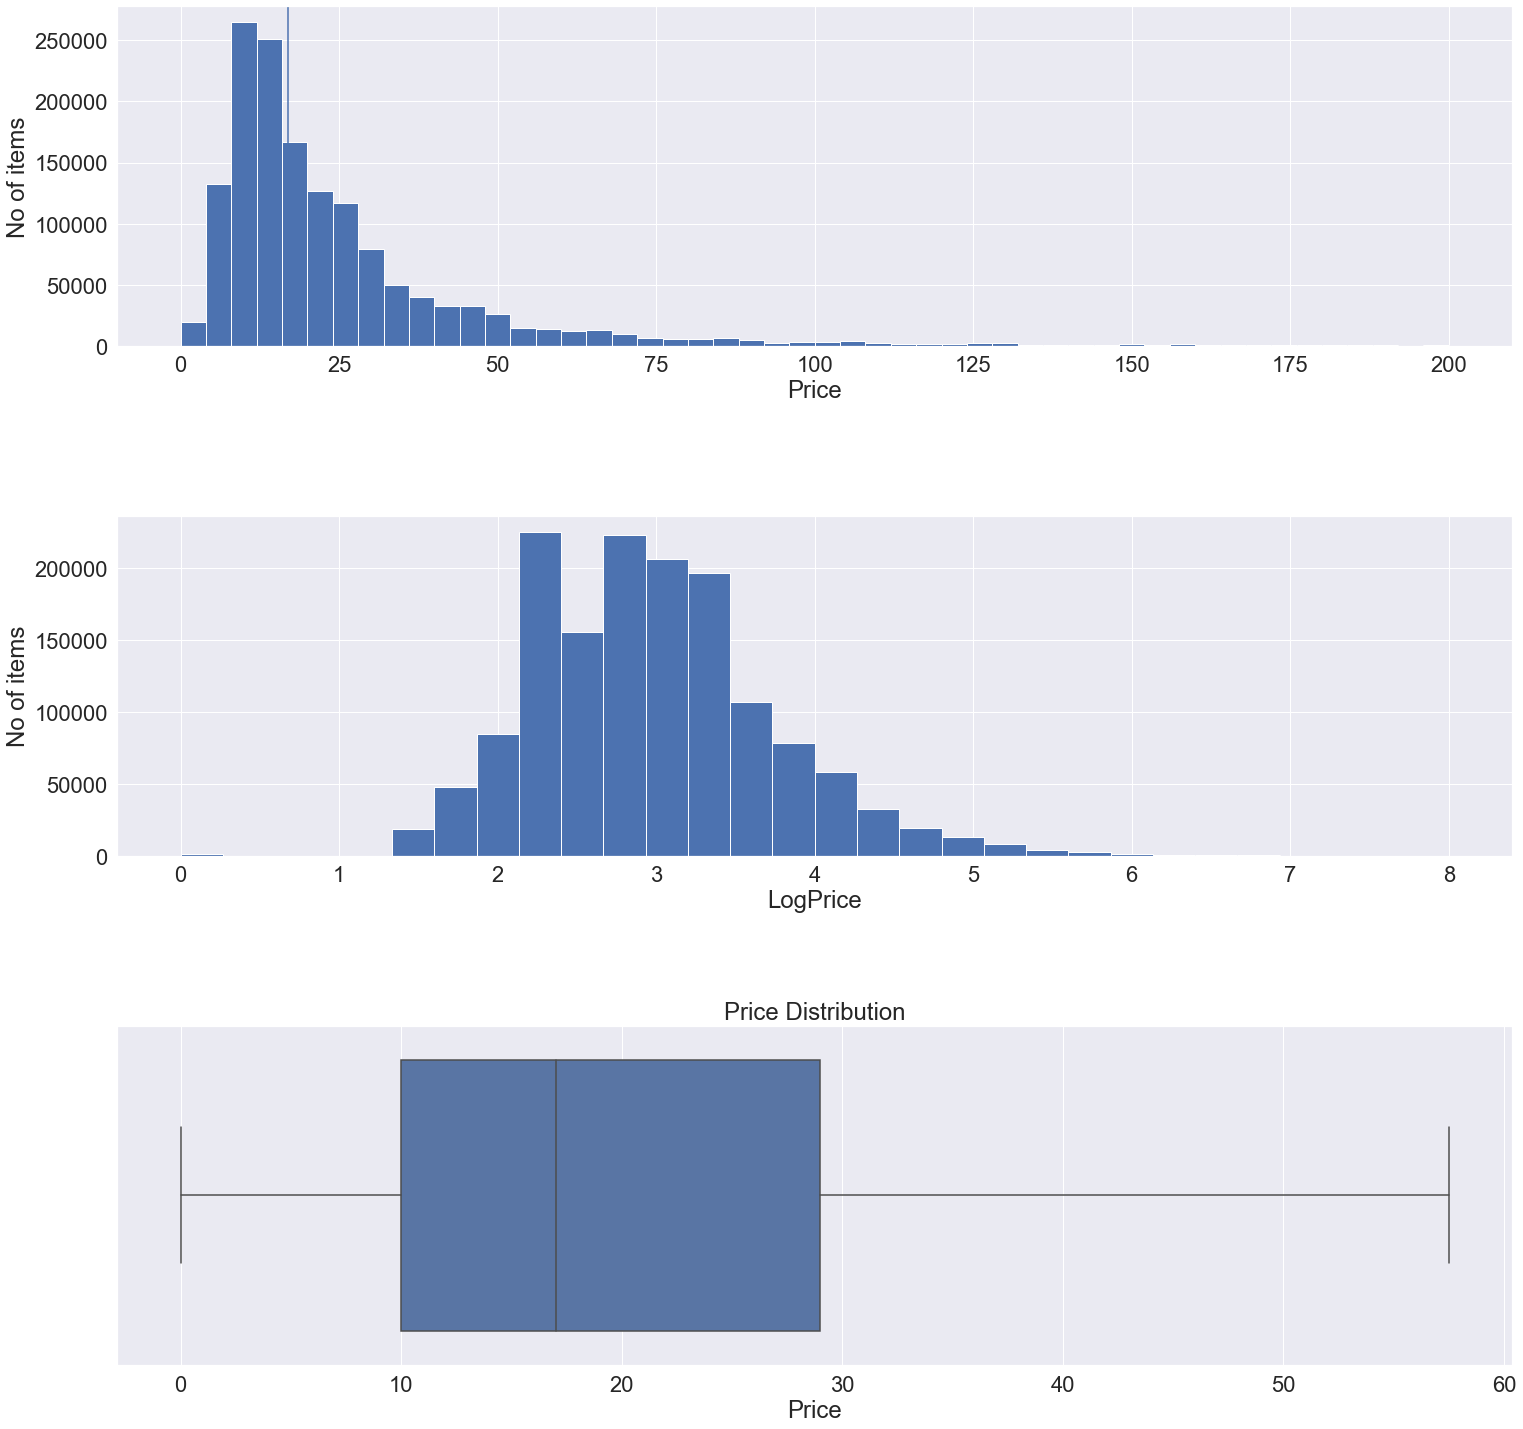

In [142]:
#sns.set(font_scale=2) 
fig, axes = plt.subplots(3, 1,figsize=(25, 25))
axes = axes.flatten()

present_axis=axes[0]
present_axis.hist(train.price,bins=50,range=[0,200],label="Price")
present_axis.set_xlabel('Price')
present_axis.set_ylabel('No of items')
present_axis.axvline(train.price.median(), color='b')

present_axis=axes[1]
present_axis.hist(np.log(train.price+1),bins=30,range=[0,8],label="Price")
present_axis.set_xlabel('LogPrice')
present_axis.set_ylabel('No of items')

present_axis=axes[2]
sns.boxplot(train.price,showfliers=False,ax=present_axis)
present_axis.set_xlabel('Price')
present_axis.set_title('Price Distribution')

plt.subplots_adjust(hspace = 0.5)
plt.show()


#### Step-4 (Analyzing Shipping Information)

Here, we can see that for items which have lesser price, the shipping had to be paid by the buyer for profit reasons. Also, as the price increases, we can see that the shipping charges have been paid by the seller.. And there is a lot of overlap for items where both buyer and seller have been charged

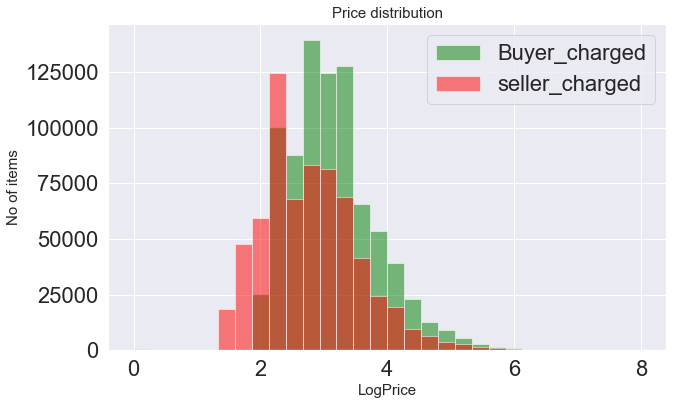

In [155]:
#Ref: https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#Ref: https://stackoverflow.com/questions/28398200/matplotlib-plotting-transparent-histogram-with-non-transparent-edge
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.log(train[train['shipping']==0]["price"]+1),bins=30,range=[0,8],label="Buyer_charged",alpha=0.5,color='green')
ax.hist(np.log(train[train['shipping']==1]["price"]+1),bins=30,range=[0,8],label="seller_charged",alpha=0.5,color='red')
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('LogPrice',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)
plt.legend(loc='upper right')

plt.show()

#### Step-5 (Analyzing Frequent and Costly Categories)

If we see the below figure, even though items in women category are costlier, they are bought in very high number, where as mens category items are costlier but bought in very less number

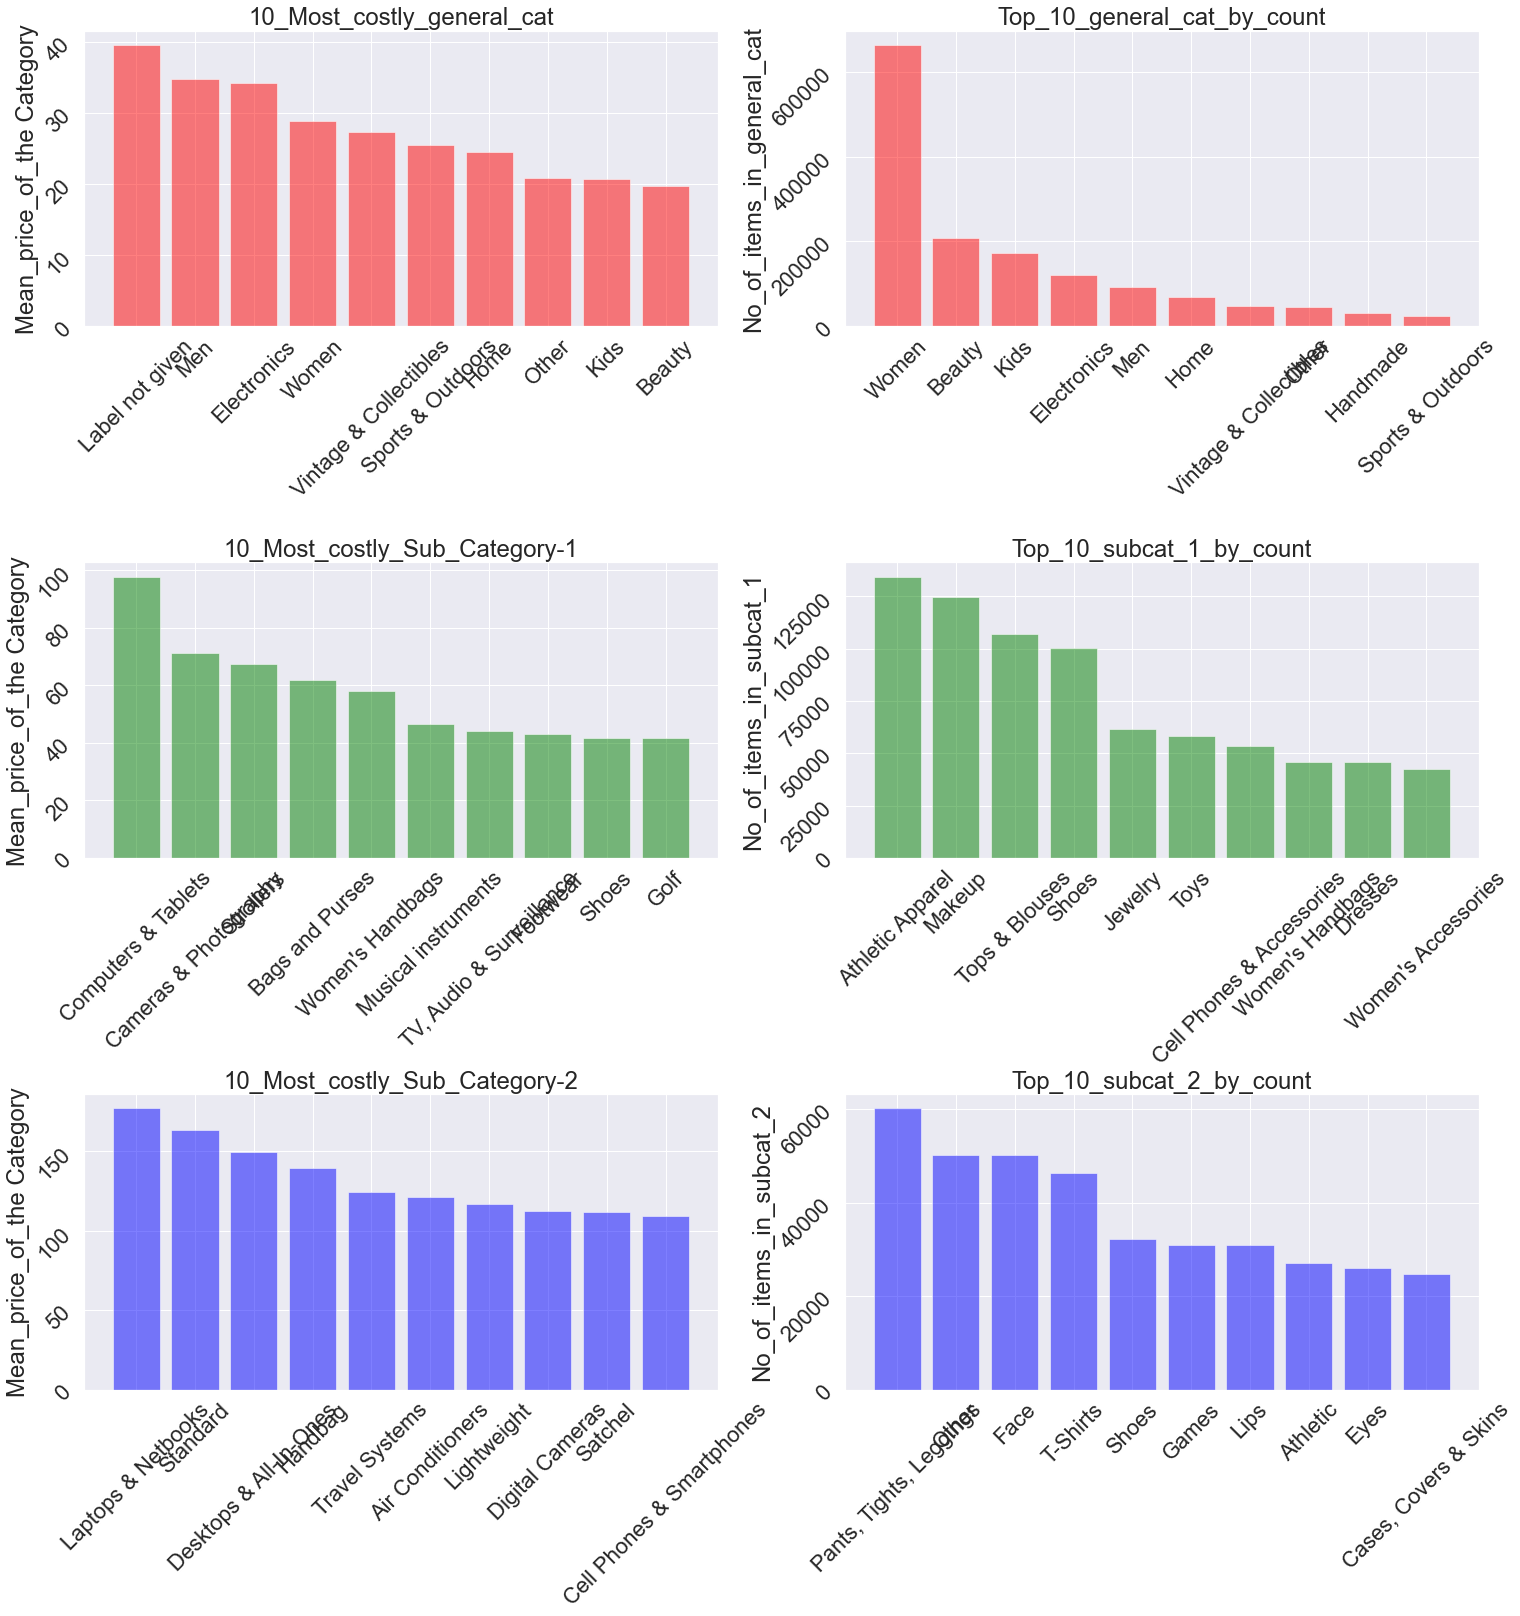

In [185]:
#sns.set(font_scale=2) 
fig, axes = plt.subplots(3, 2,figsize=(25, 25))
axes = axes.flatten()

present_axis=axes[0]
df=train.groupby("general_cat")["price"].mean().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="red",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("Mean_price_of_the Category")
present_axis.set_title('10_Most_costly_general_cat')
present_axis.tick_params(labelrotation=45)

present_axis=axes[1]
df=train.groupby("general_cat").size().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="red",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("No_of_items_in_general_cat")
present_axis.set_title('Top_10_general_cat_by_count')
present_axis.tick_params(labelrotation=45)

present_axis=axes[2]
df=train.groupby("subcat_1")["price"].mean().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="green",alpha=0.5)
#present_axis.set_xlabel('Sub Category-1')
present_axis.set_ylabel("Mean_price_of_the Category")
present_axis.set_title('10_Most_costly_Sub_Category-1')
present_axis.tick_params(labelrotation=45)

present_axis=axes[3]
df=train.groupby("subcat_1").size().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="green",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("No_of_items_in_subcat_1")
present_axis.set_title('Top_10_subcat_1_by_count')
present_axis.tick_params(labelrotation=45)

present_axis=axes[4]
df=train.groupby("subcat_2")["price"].mean().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="blue",alpha=0.5)
#present_axis.set_xlabel('Sub Category-2')
present_axis.set_ylabel("Mean_price_of_the Category")
present_axis.set_title('10_Most_costly_Sub_Category-2')
present_axis.tick_params(labelrotation=45)

present_axis=axes[5]
df=train.groupby("subcat_2").size().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="blue",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("No_of_items_in_subcat_2")
present_axis.set_title('Top_10_subcat_2_by_count')
present_axis.tick_params(labelrotation=45)

plt.subplots_adjust(hspace = 0.8)
plt.show()

#### Step-5 (Analyzing Item Description and Brand Names)

For most of the items, the brand name has not been listed can be deduced from the plot(SO,may be many of the items are local goods). Second to it, most number of items have 'Pink' and "Nike" as brand names.



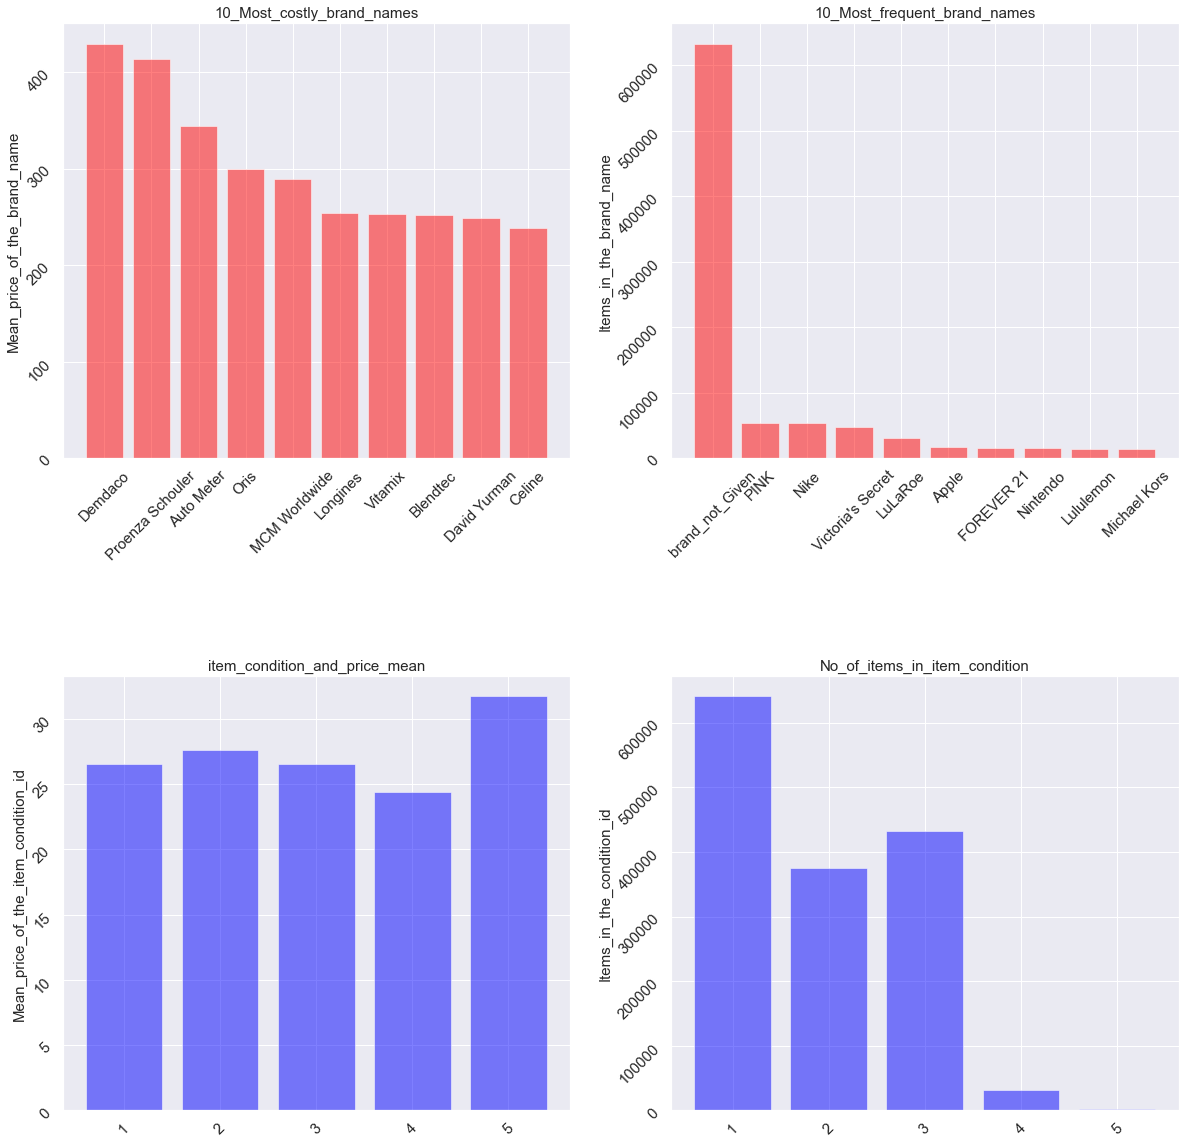

In [224]:
#sns.set(font_scale=2) 
fig, axes = plt.subplots(2, 2,figsize=(20,20))
axes = axes.flatten()

present_axis=axes[0]
df=train.groupby("brand_name")["price"].mean().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="red",alpha=0.5)
present_axis.set_ylabel("Mean_price_of_the_brand_name",size=15)
present_axis.set_title('10_Most_costly_brand_names',size=15)
present_axis.tick_params(labelrotation=45,labelsize=15)

present_axis=axes[1]
df=train.groupby("brand_name").size().sort_values(ascending=False)[:10]
present_axis.bar(df.index,df.values,color="red",alpha=0.5)
present_axis.set_ylabel("Items_in_the_brand_name",size=15)
present_axis.set_title('10_Most_frequent_brand_names',size=15)
present_axis.tick_params(labelrotation=45,labelsize=15)

present_axis=axes[2]
df=train.groupby("item_condition_id")["price"].mean().sort_values(ascending=False)
present_axis.bar(df.index,df.values,color="blue",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("Mean_price_of_the_item_condition_id",size=15)
present_axis.set_title('item_condition_and_price_mean',size=15)
present_axis.tick_params(labelrotation=45,labelsize=15)

present_axis=axes[3]
df=train.groupby("item_condition_id").size().sort_values(ascending=False)
present_axis.bar(df.index,df.values,color="blue",alpha=0.5)
#present_axis.set_xlabel('General Category')
present_axis.set_ylabel("Items_in_the_condition_id",size=15)
present_axis.set_title('No_of_items_in_item_condition',size=15)
present_axis.tick_params(labelrotation=45,labelsize=15)

plt.subplots_adjust(wspace = 0.2)
plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Step-6 (Correlation Analysis)

In [232]:
#https://www.pythonfordatascience.org/anova-python/
rp.summary_cont(train['price'].groupby(train['general_cat']))

,N,Mean,SD,SE,95% Conf.,Interval
general_cat,,,,,,
Beauty,207828,19.6715,21.3601,0.0469,19.5797,19.7634
Electronics,119631,34.1918,64.0376,0.1851,33.8289,34.5547
Handmade,30840,18.1544,27.7564,0.1581,17.8446,18.4642
Home,67871,24.5366,24.4171,0.0937,24.3529,24.7203
Kids,171689,20.6423,22.7309,0.0549,20.5348,20.7498
Label not given,10716,39.5719,63.6638,0.6150,38.3663,40.7774
Men,93363,34.6933,41.2642,0.1350,34.4287,34.9580
Other,45351,20.8098,29.8478,0.1402,20.5351,21.0845
Sports & Outdoors,24331,25.5346,29.3240,0.1880,25.1661,25.9030


<a id='Feature Extraction from text data'></a>

### Feature Extraction from text data

#### Step- 1 (Cleaning)

Let us do basic Text Cleaning for item description and Add few features like text length, text polarity etc

In [277]:
stop_words= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [278]:
#remove punctuation and numbers
def clean(text):
    text=" ".join([v for v in text.split() if v not in stop_words])
    text = " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'[0-9]+', '', text)
    text= " ".join([v.lower() for v in text.split() if len(v)>3  ])    
    
    return text

In [279]:
def indirect_features(df):
    #Word count in each text:
    df['count_word']=df["item_description"].apply(lambda x: len(str(x).split()))

    #Unique word count
    df['count_unique_word']=df["item_description"].apply(lambda x: len(set(str(x.lower()).split())))

    #Letter count
    df['count_letters']=df["item_description"].apply(lambda x: len(str(x)))
    
    #polarity of the description
    df["Polarity"]=df["item_description"].apply(lambda x: TextBlob(x).sentiment.polarity)
    return df

In [280]:
train['clean_item_description'] = train['item_description'].apply(lambda x: clean(x))
test['clean_item_description'] = test['item_description'].apply(lambda x: clean(x))

indirect_features(train)
indirect_features(test)

print (train.shape)
print (test.shape)

(1482535, 16)
(693359, 15)


In [284]:
#Have a checkpoint to avoid go through all the steps again

train.to_csv("train1.csv")
test.to_csv("test1.csv")

In [72]:
train = pd.read_csv("train1.csv",index_col="Unnamed: 0")
test = pd.read_csv("test1.csv",index_col="Unnamed: 0")

train.head()

C:\Users\ramya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,clean_item_description,count_word,count_unique_word,count_letters,Polarity
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,brand_not_Given,10.0,1,No description yet,Men,Tops,T-shirts,description,3,3,18,0.000000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,this keyboard great condition works like came ...,36,30,188,0.900000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,adorable hint lace hole back pale pink also av...,29,23,124,0.136250
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,brand_not_Given,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,tags leather horses retail each stand foot hig...,32,31,173,0.232121
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,brand_not_Given,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,complete certificate authenticity,5,5,41,0.100000


In [73]:
#Dropping columns whose price=0
train=train[train.price != 0].reset_index(drop=True)

In [74]:
ntrain=len(train)

In [75]:
print (train.shape)
print (test.shape)

(1481661, 16)
(693359, 15)


#### Step-2 (Mean Encoding General Category/Sub Category-1/Sub Caetgory-2 with Kmeans regularization)

Split your data in 5 folds with sklearn.model_selection.KFold with shuffle=True argument.

Iterate through folds: use all but the current fold to calculate mean target(here price) for each level column_to_encoded(Ex: general_Cat) , and fill the current fold.

This should be done on train data and then tranformed to test data

So, before that we should check whether all the General Category/Sub Category-1/Sub Caetgory-2 are similar in train and test

In [14]:
print (set(train.general_cat)==set(test.general_cat))
print (set(train.subcat_1)==set(test.subcat_1))
print (set(train.subcat_2)==set(test.subcat_2))

True
True
False


Since category 2 has items which are not in train we cant mean encode it

In [76]:
def mean_encoding_kmean(df,column_to_encoded,new_column_name):
    
    kf = KFold(n_splits = 10,shuffle =True)

    for train_ind, val_ind in kf.split(df) :

        train_data , val_data = df.iloc[train_ind], df.iloc[val_ind]

        df.at[val_ind , new_column_name] = \
        val_data[column_to_encoded].map(train_data.groupby(column_to_encoded)['price'].mean())
        
    df[new_column_name].fillna(df.price.mean(), inplace=True) 
    return df

In [77]:
train=mean_encoding_kmean(train,"general_cat","general_cat_enc")

In [78]:
train=mean_encoding_kmean(train,"subcat_1","subcat_1_enc")

In [79]:
train[train.subcat_1=="Tops"].price.mean()

19.014216281895504

No we should map these values into test_set

In [80]:
test["general_cat_enc"]=test["general_cat"].map(train.groupby("general_cat")['general_cat_enc'].mean())
test["subcat_1_enc"]=test["subcat_1"].map(train.groupby("subcat_1")['subcat_1_enc'].mean())

In [81]:
print (train.shape)
print (test.shape)

(1481661, 18)
(693359, 17)


#### Step-3 (Vectorizing Name)

In [21]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 10000

In [82]:
merge=pd.concat([train.drop(["price","train_id"],axis=1),test.drop(["test_id"],axis=1)])

In [83]:
merge.shape

(2175020, 16)

In [59]:
cv = CountVectorizer(min_df=50)
X_name = cv.fit_transform(merge['name'])

In [60]:
X_name.shape

(2175020, 9443)

#### Step-4 (Vectorizing unclean Description)

Here I have taken only unigrams for  item description, bigrams for clean data

In [26]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,  min_df=20, stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

X_description.shape

(2175020, 10000)

#### Step-5 (Vectorizing clean description for bigrams)

For frequently occuring two words

In [84]:
merge['clean_item_description'].fillna(" ",inplace=True)

In [28]:
tv = TfidfVectorizer(max_features=2000,ngram_range=(2, 2),  min_df=20, stop_words='english')
X_clean_description = tv.fit_transform(merge['clean_item_description'])

X_clean_description.shape

(2175020, 2000)

#### Step-5 (Vectorizing Brand)

In [29]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [30]:
X_brand.shape

(2175020, 5288)

#### Step-7 (Vectorizing General cat, subcat-1, subcat-2,brand)

We are Vectorizing general and both subcategories, but we should replace very less frequent categories by "others" because they are very few in numbers. DUe to memory errors I did not do onehot encoding

In [31]:
def thresholding(df,colum,threshold):
    counts = df[colum].value_counts()
    repl = counts[counts <= threshold].index
    df[colum].replace(repl, 'other')
    
    return df

In [32]:
cv = CountVectorizer()
X_general_cat = cv.fit_transform(thresholding(merge,"general_cat",50000)["general_cat"])

In [33]:
cv = CountVectorizer()
X_subcat_1 = cv.fit_transform(thresholding(merge,"subcat_1",500)["subcat_1"])
X_subcat_1.shape

(2175020, 144)

In [34]:
cv = CountVectorizer()
X_subcat_2 = cv.fit_transform(thresholding(merge,"subcat_2",200)["subcat_2"])
X_subcat_2.shape

(2175020, 973)

In [35]:
cv = CountVectorizer()
X_brand_name = cv.fit_transform(thresholding(merge,"brand_name",200)["brand_name"])
X_brand_name.shape

(2175020, 5466)

In [36]:
merge.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,clean_item_description,count_word,count_unique_word,count_letters,Polarity,general_cat_enc,subcat_1_enc
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,brand_not_Given,1,No description yet,Men,Tops,T-shirts,description,3,3,18,0.000000,34.688302,18.988865
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,this keyboard great condition works like came ...,36,30,188,0.900000,34.110508,98.318785
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,adorable hint lace hole back pale pink also av...,29,23,124,0.136250,28.897467,18.270498
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,brand_not_Given,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,tags leather horses retail each stand foot hig...,32,31,173,0.232121,24.588951,21.582699
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,brand_not_Given,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,complete certificate authenticity,5,5,41,0.100000,28.882354,27.502685


#### Step-8 (Getting dummies for Item-description)

In [85]:
merge=pd.get_dummies(merge,columns=["item_condition_id"]).drop(columns=["item_condition_id_1"])

<a id='Building the Model'></a>

### Building the Model

#### Step-1 (Merging all vectors and splitting  at ntrain)

First we should merge all the features and then seperate train and test

In [92]:
X_train = hstack((X_name,X_description,X_clean_description,X_brand,\
                 X_general_cat,X_subcat_1,X_subcat_2)).tocsr()[:ntrain]

X_test = hstack((X_name,X_description,X_clean_description,X_brand,\
                 X_general_cat,X_subcat_1,X_subcat_2)).tocsr()[ntrain:]

In [62]:
X_train.shape

(1481661, 27863)

#### Step-2 (dropping columns from merge dataframe and splitting at ntrain)

In [86]:
merge.drop(columns=["name","category_name","brand_name","shipping","item_description",\
                   "general_cat","subcat_1","subcat_2","clean_item_description"],axis=1,inplace=True)

merge.shape

(2175020, 10)

#### Step-3 (Normalizing indirect features of text)

In [139]:
def normalization(df, cols):
    for col in cols:
        transformer = Normalizer().fit_transform(df[col].values.reshape(1, -1))
        df.loc[:, col]=transformer[0]
        #print (transformer[0])
        
    return df      
        

In [143]:
merge=normalization(merge, ["count_word","count_unique_word","count_letters","general_cat_enc","subcat_1_enc"])

#### Step-3 (Normalizing indirect features of text)

In [148]:
X_train = hstack((csr_matrix(merge.values[:ntrain]),X_train))

X_test = hstack((csr_matrix(merge.values[ntrain:]),X_test))

y_train=train["price"]

In [149]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)

(1481661, 27873)
(1481661,)
(693359, 27873)


#### Step-4 (Breaking into Validation set)

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split( X_train, y_train, test_size=0.3, random_state=42)

In [151]:
print (X_train.shape)
print (y_train.shape)
print (X_valid.shape)
print (y_valid.shape)

(1037162, 27873)
(1037162,)
(444499, 27873)
(444499,)


#### Step-4 (gridsearchCV LightGBM regressor)

In [158]:
from lightgbm import LGBMRegressor
gridParams = {
    'learning_rate': [ 0.1,0.5],
    'n_estimators': [ 200,500],
    'num_leaves': [20,80],
    'boosting_type' : ['gbdt'],
    'max_depth' : [2,5,8]
}
lgbm_params ={'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression'
        }
model = LGBMRegressor(**lgbm_params)
# Create the grid
grid = GridSearchCV(model, gridParams, verbose=0)
# Run the grid
grid.fit(X_train, y_train,verbose=False)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

Best parameters found by grid search are: {'boosting_type': 'gbdt', 'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 500, 'num_leaves': 80}
Best score found by grid search is: 0.4816278393844418


#### Step-4 (Random forest Regressor)

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_log_error
#np.sqrt(mean_squared_log_error(y_test, predictions))

In [ ]:
param_dist = {'n_estimators': [50,300,500],
               'min_samples_split': [4,8],
              "max_depth":[None,80,120]
                           }
RFregr = RandomForestRegressor()
n_iter_search = 20
Reg1 = RandomizedSearchCV(RFregr, param_distributions=param_dist,
                                     n_jobs=-1, n_iter=n_iter_search, cv=3)

Reg1.fit(X_train, y_train)

In [ ]:
print('Best parameters found by random search are:', Reg1.best_params_)
print('Best score found by random search is:', Reg1.best_score_)

#### Step-5 (Fit the model and predict)